# Data Exploration and Statin Analysis on FHIR
This notebook shows an example of using [tools for working with FHIR data](https://github.com/google/fhir-py) to understand a complex dataset and run a simplified quality measure over it.

# Setup
Users will need to first install the required tooling. Until it's on PyPI it can be pulled from source. If you're using a managed notebook like [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench), you can open a terminal and copy this in:

```
git clone https://github.com/google/fhir-py.git
cd fhir-py
./install_all.sh
```

See the [README](https://github.com/google/fhir-py#readme) for details on installation.

# Environment setup
This example has been tested in a [Vertex AI Workbench notebook](https://cloud.google.com/vertex-ai-workbench), but can be adapted to work in any Jupyter-based notebook. The key item is that you will need a GCP project and the ability to use BigQuery. The cell below sets up the BigQuery client and creates a new dataset that will be used for this analysis. It also creates a BigQuery view "runner", which is used to apply declarative views of FHIR in BigQuery. Examples of using it are below.

In [1]:
from google.cloud import bigquery
from google.fhir.views import r4, bigquery_runner

# The BigQuery dataset containing FHIR data. This may be read-only to the user.
fhir_dataset = 'bigquery-public-data.fhir_synthea'

# The BigQuery dataset where we will create views, value sets, and other derived tables
# as needed. This must be writeable by the user. This will use the default project
# where this notebook is running.
analysis_dataset = 'statin_analysis_example'

client = bigquery.Client()

# Create our the dataset itself.
dataset = bigquery.DatasetReference(client.project, analysis_dataset)
dataset.location = "US"
dataset = client.create_dataset(dataset, exists_ok=True)


runner = bigquery_runner.BigQueryRunner(
    client,
    fhir_dataset=fhir_dataset,
    view_dataset=analysis_dataset,
    snake_case_resource_tables=True)

# Explore the data
Getting a general feeling for the data is an important first step in any analysis. So let's create some views of FHIR resources and take a look at common fields.

In [2]:

# Load views based on the base FHIR R4 profile definitions.
views = r4.base_r4()

# Create shorthand names for resources we will work with.
conds = views.view_of('Condition')
meds = views.view_of('MedicationRequest')
obs = views.view_of('Observation')
pats = views.view_of('Patient')

Let's take a look at some observation resources by creating FHIRPath expressions to select the items we're interested in.

Notice that tab completion works for FHIR fields and FHIRPath functions, so users don't need to switch back and forth to FHIR documentation as much.


In [3]:
runner.to_dataframe(
    obs.select({
        'category': obs.category.coding.code,
        'code_display': obs.code.coding.display,
        'status': obs.status
        }),
        limit=5)

,category,code_display,status
0,[vital-signs],[Blood Pressure],final
1,[vital-signs],[Blood Pressure],final
2,[vital-signs],[Blood Pressure],final
3,[vital-signs],[Blood Pressure],final
4,[vital-signs],[Blood Pressure],final


Of course just a sample of codes isn't too useful -- we really want a summary of what codes exist in a field and how many there are. Fortunately, the BigQuery runner supports a `summarize_codes` method that accepts a view and a field name and does exactly that.

Also notice this handles many millions of records in seconds thanks to the underlying BigQuery execution engine.

In [4]:
runner.summarize_codes(obs, obs.category)

,system,code,display,count
0,http://hl7.org/fhir/observation-category,laboratory,laboratory,134975846
1,http://hl7.org/fhir/observation-category,vital-signs,vital-signs,61942927
2,http://hl7.org/fhir/observation-category,survey,survey,11381764
3,http://hl7.org/fhir/observation-category,procedure,procedure,515603
4,http://hl7.org/fhir/observation-category,social-history,social-history,417444
5,http://hl7.org/fhir/observation-category,exam,exam,317776
6,http://hl7.org/fhir/observation-category,vital-sign,vital-sign,97951
7,http://hl7.org/fhir/observation-category,imaging,imaging,97951
8,http://hl7.org/fhir/observation-category,therapy,therapy,24559


We can also do so for conditions or other resources:

In [5]:
runner.summarize_codes(conds, conds.code)

,system,code,display,count
0,http://snomed.info/sct,444814009,Viral sinusitis (disorder),1231862
1,http://snomed.info/sct,195662009,Acute viral pharyngitis (disorder),699685
2,http://snomed.info/sct,10509002,Acute bronchitis (disorder),568613
3,http://snomed.info/sct,162864005,Body mass index 30+ - obesity (finding),529938
4,http://snomed.info/sct,72892002,Normal pregnancy,500825
...,...,...,...,...
160,http://snomed.info/sct,46177005,End stage renal disease (disorder),7
161,http://snomed.info/sct,287191006,Suicide - suffocation,6
162,http://snomed.info/sct,44301001,Suicide,3
163,http://snomed.info/sct,425048006,"Non-small cell carcinoma of lung, TNM stage 2 ...",2


# Creating Views
FHIR Data is complicated, but there is usually a flat, tabular form of it that can satisfy a given use case and data set.

For example, imagine we need a simple table of patients with their current address. This isn't trivial to query since the address is a nested repeated field. Fortunately we can build a FHIRPath expression to find the current address and create a flattened view using that. 

(This can vary by dataset, but in this case we determine the current address by finding the first address that does not have a period attached to it.)

In [6]:
# For this dataset we interpret the current address as one where period is empty.
current = pats.address.where(pats.address.period.empty()).first()

simple_pats = pats.select({
    'id': pats.id,
    'gender': pats.gender,
    'birthdate': pats.birthDate,
    'street': current.line.first(),
    'city': current.city, 
    'state': current.state,
    'zip': current.postalCode
    })

runner.to_dataframe(simple_pats, limit = 5)

,id,gender,birthdate,street,city,state,zip
0,7f932089-f060-4ad9-89f3-831d236eb8c4,female,2017-08-21,311 Lebsack Meadow,Hatfield,Massachusetts,01038
1,13204eb5-ae78-4e72-92b9-6058f56cbb3c,male,2011-10-28,520 Roob Drive Apt 17,Hatfield,Massachusetts,01038
2,6aaf6b90-6667-4004-b510-18cfa32a32d5,female,2002-05-14,1049 Powlowski Haven,Hatfield,Massachusetts,01038
3,f59b1aa1-a0e4-4a38-8095-149a791313cc,male,2013-06-11,484 Mante Park,Hatfield,Massachusetts,01038
4,079116c6-8e7d-4a1b-9421-b736380caab5,female,2003-11-04,545 Prosacco Alley Suite 97,Hatfield,Massachusetts,01038


That's nice, but suppose we want to create it as an actual BigQuery view -- basically a virtual table that can be easily used by *any* application that uses BigQuery. We can simply turn that definition into a BigQuery view:

In [7]:
runner.create_bigquery_view(simple_pats, 'patients')

In [8]:
%%bigquery
SELECT * FROM statin_analysis_example.patients
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.75rows/s]


,id,gender,birthdate,street,city,state,zip
0,f367a74b-6fe7-46d3-8e13-b023dd2bb4ab,female,2007-07-11,505 Vandervort Row,Hatfield,Massachusetts,01038
1,c1382d13-d64b-4c43-a95b-9ecfd0a4a548,female,2013-06-07,961 Stoltenberg Parade,Hatfield,Massachusetts,01038
2,c4c87e82-74de-4af6-86e8-8ea21b11716c,female,1964-02-02,305 Gusikowski Manor,Hatfield,Massachusetts,01038
3,4206023e-f025-477f-8ada-c58155697c55,female,2010-10-30,699 Cummerata Manor,Hatfield,Massachusetts,01038
4,e2231e26-e03d-4e83-b5f6-d4196bbca245,female,2002-07-19,922 Welch Boulevard,Hatfield,Massachusetts,01038


Now we have a nice, flattened patients table that meets the needs of our system and data. We'll create similarly simple views of other resources as well, but first we need to introduce another concept: value sets. 

# Using the Value Sets
Code value sets are a central part of nearly any significant FHIR-based data analysis. For instance, the car gap analysis below needs to query for statin medications, LDL tests, and other concepts. Users could track down specific code values, but there's a better way: we will use predefined, curated value sets from the [Value Set Authority Center](https://vsac.nlm.nih.gov/) that define this content.

First we need to obtain the content. Users may create a value set table themselves and populate it as needed, but this library also supports the ability to connect to a FHIR terminology server and retrieve the needed values. The example below shows connecting to VSAC's terminology server and getting code values for statins, CHD, and LDL tests:

In [9]:
# Value set URLs used in the queries
STATIN_MEDS = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.117.1.7.1.225'
CHD_OR_RISK_EQUIV = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.600.862'
LDL_TEST = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.464.1003.198.11.1029'

In [10]:
import getpass 
from google.fhir.r4.terminology import terminology_service_client

api_key = getpass.getpass('UMLS API KEY: ')

tx_client = terminology_service_client.TerminologyServiceClient({
    'http://cts.nlm.nih.gov/fhir/': ('apikey', api_key),
})
runner.materialize_value_set_expansion((STATIN_MEDS, LDL_TEST, CHD_OR_RISK_EQUIV), tx_client)

UMLS API KEY:  ····································


Now that we've downloaded that content, let's take a look at the value_set_codes table it produced:

In [11]:
%%bigquery
SELECT * FROM 
statin_analysis_example.value_set_codes
WHERE valueseturi = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.464.1003.198.11.1029'

Downloading: 100%|██████████| 9/9 [00:01<00:00,  6.46rows/s]


,valueseturi,valuesetversion,system,code
0,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,18261-8
1,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,18262-6
2,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,49132-4
3,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,13457-7
4,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,39469-2
5,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,22748-8
6,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,55440-2
7,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,12773-8
8,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,2089-1


We now have the value sets needed for some analysis stored in BigQuery, so let's use them for an important use case: identifying gaps in care.


# Identifying Statin Therapy Care Gaps
This section analyzes the use of statin therapy for patients who have been diagnosed with Coronary Heart Disease (CHD) or have equivalent risks. We achieve this by first identifying a cohort of patients and then measuring the percentage of them with the recommended therapy. 

Some of this content is based on the [Statin Therapy eCQM](https://ecqi.healthit.gov/system/files/ecqm/measures/CMS347v1.html).

## The cohort:
Patients who have either of the following during the measurement period:
* Coronary Heart Disease or equivalent risks (as defiend by CMS) OR
* An LDL-C greater than or equal to 180

## The measure:
The percentage of cohort members who have statin therapy.

We start by setting some measure parameters, like the start and end date for our program:

In [12]:
import datetime

# Start and end dates for our analysis
start_date = datetime.date(2018,1,1)
end_date = datetime.date(2019,1,1)

Now let's take the complex FHIR data and create some simple views for our needs. Let's start with a view of all LDL values:

In [13]:
ldl_obs = obs.select({
    'patient': obs.subject.idFor('Patient'),
    'value': obs.value.ofType('Quantity').value,
    'unit': obs.value.ofType('Quantity').unit,
    'test': obs.code.coding.display.first(),
    'date': obs.effective.ofType('dateTime')
    }).where(obs.code.memberOf(LDL_TEST)) 

runner.to_dataframe(ldl_obs, limit=10)

,patient,value,unit,test,date
0,971c9f2d-11a9-496f-9166-3861e19d1e1d,134.216612,mg/dL,Low Density Lipoprotein Cholesterol,2018-05-08T23:28:01+00:00
1,e613f947-7898-4a93-934f-9baef05df922,84.858008,mg/dL,Low Density Lipoprotein Cholesterol,2017-03-27T09:08:44+00:00
2,634dc36d-1377-4e6d-99b5-5be040d2cb12,137.517456,mg/dL,Low Density Lipoprotein Cholesterol,2017-03-02T07:08:03+00:00
3,9f66b1ab-1960-4719-9df1-d2bc4fe28a9e,104.552939,mg/dL,Low Density Lipoprotein Cholesterol,2013-09-26T21:29:19+00:00
4,35e08209-69bf-48a3-ae99-df1efbf0dc14,115.731848,mg/dL,Low Density Lipoprotein Cholesterol,2007-10-01T05:50:42+00:00
5,abcf02b1-819e-4024-9ce5-7ae2a7012c68,78.946073,mg/dL,Low Density Lipoprotein Cholesterol,2013-05-18T03:49:00+00:00
6,0e855801-e920-4a7c-895f-bf9440a54e73,72.990413,mg/dL,Low Density Lipoprotein Cholesterol,2014-06-02T20:40:21+00:00
7,4e9f2e6d-1ff1-4656-80ad-ed9103584c8e,89.497321,mg/dL,Low Density Lipoprotein Cholesterol,2011-05-24T17:26:26+00:00
8,658e600e-b4df-468f-8d02-6eee6c73de33,137.017050,mg/dL,Low Density Lipoprotein Cholesterol,2011-08-14T18:17:58+00:00
9,64ba0f3c-5908-42fd-9c1a-85949b8b6f06,65.299842,mg/dL,Low Density Lipoprotein Cholesterol,2013-05-06T14:51:47+00:00


Now we can create it as a BigQuery view -- and *all* analysis that needs LDL values can simply use this nice, flattened table for that use case.

We recommend creating such simple, flattened tables for each major part of your analysis. That way they can be inspected and validated independently of the measure logic, making it much easier to separate and solve data and logic issues.

In [14]:
runner.create_bigquery_view(ldl_obs, 'ldl_obs')


Let's do some minimal validation by plotting a random sample of all LDL values. 

You can see a clear bimodal distribution in this example. This is an artifact of the branching logic synthetic data generator used to create the data, where some generated patients are branched with conditions.

In [15]:
%%bigquery ldl_values
SELECT value FROM statin_analysis_example.ldl_obs WHERE RAND() < 0.01

Downloading: 100%|██████████| 50349/50349 [00:01<00:00, 33860.90rows/s]


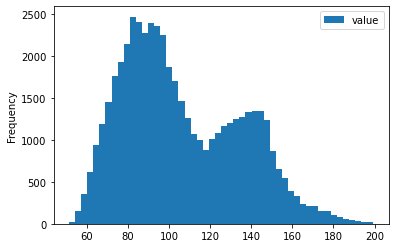

In [16]:
ldl_values.plot.hist(bins=50);

We can also layer views on top of one another. For example, since the measure is scoped to 2018, it might be convenient to create a view of LDL values only for that year.

Fortunately we can just add conditions to the previous view:

In [17]:
ldl_obs_2018 = ldl_obs.where(ldl_obs.date >= start_date, 
                             ldl_obs.date < end_date)

runner.create_bigquery_view(ldl_obs_2018, 'ldl_obs_2018')

Now we'll take a similar approach to another part of our analysis: a view of Coronary Heart Disease conditions or requivalent risks.

In [18]:
chd_or_equiv_risks = conds.select({
        'patient': conds.subject.idFor('Patient'),
        'date': conds.onset.ofType('dateTime'),
        'code': conds.code.coding.code.first(),
        'display': conds.code.coding.display.first()
        }
    ).where(
        conds.code.memberOf(CHD_OR_RISK_EQUIV))

runner.create_bigquery_view(chd_or_equiv_risks, 'chd_or_equiv_risks')
runner.to_dataframe(chd_or_equiv_risks, limit=10)

,patient,date,code,display
0,4c87f2fa-2a0c-42f2-a48b-3680c068619e,2000-09-10T19:28:11+00:00,53741008,Coronary Heart Disease
1,a45f5740-e04c-4e56-840b-1e97e3d1da37,1983-06-30T09:15:03+00:00,53741008,Coronary Heart Disease
2,0742b12c-e6f2-4031-bb4b-4d340e5de244,1964-06-20T03:17:08+00:00,44054006,Diabetes
3,1d106c41-3f97-4a5b-a339-739013e6c0fa,2019-09-20T09:19:14+00:00,53741008,Coronary Heart Disease
4,e7fc64bf-0378-4778-ae15-833176cf77d4,1997-11-02T12:16:50+00:00,53741008,Coronary Heart Disease
5,1b0f8c62-a48a-47ae-ac16-9c116366c424,1996-10-25T16:26:17+00:00,127013003,Diabetic renal disease (disorder)
6,cd4db121-fa97-485f-9663-9b012e9e877b,2010-02-01T21:46:46+00:00,44054006,Diabetes
7,2c2ea7e6-e80d-4d00-86b9-da21bd752e59,2018-05-20T15:28:46+00:00,53741008,Coronary Heart Disease
8,f35a278b-e932-4d25-9a90-f69bf6c4b9f7,2016-10-20T11:01:44+00:00,53741008,Coronary Heart Disease
9,2834f6a2-b5bb-485e-88ab-c10d6f4491f5,1994-06-30T17:44:17+00:00,44054006,Diabetes


In [19]:
chd_or_equiv_risks_2018 = chd_or_equiv_risks.where(
        chd_or_equiv_risks.date >= start_date,
        chd_or_equiv_risks.date < end_date)

runner.create_bigquery_view(chd_or_equiv_risks_2018, 'chd_or_equiv_risks_2018')

Let's look at the condition codes to see if this looks reasonable. Notice that the value set defined for this analysis includes diabetes as a risk equivalent here, as seen in the reulting counts:

In [20]:
%%bigquery
SELECT code, display, COUNT(*) count
FROM statin_analysis_example.chd_or_equiv_risks_2018
GROUP BY code, display ORDER BY count DESC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.54rows/s]


,code,display,count
0,53741008,Coronary Heart Disease,2173
1,44054006,Diabetes,1541
2,127013003,Diabetic renal disease (disorder),853
3,427089005,Male Infertility,3
4,427089005,Diabetes from Cystic Fibrosis,1


And now for Statin medications. We could create separate base and year-specific views as well, but will just create one to keep the example short:

In [21]:
statin_meds_2018 = meds.select({
    'patient': meds.subject.idFor('Patient'),
    'date': meds.authoredOn
    }).where(
        meds.medication.ofType('CodeableConcept').memberOf(STATIN_MEDS),
        meds.authoredOn >= start_date,
        meds.authoredOn < end_date
        )

runner.create_bigquery_view(statin_meds_2018, 'statin_meds_2018')
runner.to_dataframe(statin_meds_2018, limit=5)

,patient,date
0,12d8a421-14f7-4012-bd46-e9d2edb52c50,2018-04-20T18:08:59+00:00
1,1e462029-8b6e-4dac-a5b4-a0289cd656fd,2018-11-05T14:05:13+00:00
2,b491c3c8-0fd5-4488-bf38-6e1fb6eb129f,2018-05-11T14:37:32+00:00
3,cd28fef1-2e2b-4550-a3b3-d0abbf4a6f70,2018-12-19T20:40:03+00:00
4,1dec8bcc-769b-4e09-a76a-505eeaf88bfa,2018-09-06T10:01:44+00:00


# Bringing it all together
Now we have the building blocks, so let's do our (simplified) care gap analysis itself. The key questions are for during the measurement period:

* Does the patient have high LDL?
* Does the patient have CHD or equivalent risk?
* Is the patient on statin medications?


This breaks down into a straightforward query with simple EXISTS expressions for each of the above:

In [22]:
%%bigquery
CREATE OR REPLACE VIEW statin_analysis_example.statin_usage_summary_2018 AS (
SELECT p.id,
       p.birthDate,
       p.gender,
      EXISTS(SELECT * FROM statin_analysis_example.ldl_obs_2018 l
             WHERE l.patient = p.id AND l.value > 180) has_high_ldl,
      EXISTS(SELECT * FROM statin_analysis_example.chd_or_equiv_risks_2018 c
             WHERE c.patient = p.id) has_chd_or_equiv_risk,
      EXISTS(SELECT * FROM statin_analysis_example.statin_meds_2018 m
             WHERE m.patient = p.id) has_statin
FROM statin_analysis_example.patients p)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 741.83query/s] 


""


In [23]:
%%bigquery
SELECT * FROM statin_analysis_example.statin_usage_summary_2018 LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.55rows/s]


,id,birthDate,gender,has_high_ldl,has_chd_or_equiv_risk,has_statin
0,71b79183-16f5-48f8-bb83-db37679e2613,2013-10-23,male,False,False,False
1,7129d27f-ed6d-4f1e-b74c-b34b9568adb6,1910-04-22,female,False,False,False
2,df0bdea7-c2e3-495e-b074-6bdb975cd0b5,1996-12-07,male,False,False,False
3,8deea896-a7fb-4e6d-b405-74efaf4691c9,1971-12-03,female,False,False,False
4,17c37a7c-5de9-4c4e-94da-0f6f315ac91b,2000-09-12,male,False,False,False


Finally, we apply our measure criteria and roll them up into counts, seeing exactly how many patients in this sample data are missing statin medications they should probably have:

In [24]:
%%bigquery
SELECT has_high_ldl OR has_chd_or_equiv_risk AS needs_statin,
       has_statin,
       COUNT(*) count
FROM statin_analysis_example.statin_usage_summary_2018
GROUP BY needs_statin, has_statin

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.91rows/s]


,needs_statin,has_statin,count
0,False,False,1169141
1,True,False,4701
2,True,True,2174
3,False,True,821
